## Notebook to generate figures for the ball portion (tethered) of the treadmill paper

In [31]:
import math
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.animation import FuncAnimation
import seaborn as sns

from scipy import stats, signal, io, fft, interpolate, special
from scipy.optimize import curve_fit, leastsq
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score

import postproc as ppro

import os
import glob
from tqdm import tqdm, trange

from datetime import date

In [32]:
def valid(arr):
    return arr[~np.isnan(arr)]

path = '/media/tuthill/turritopsis/grant/data'

### Load the data and do some postprocessing

In [6]:
df = pd.read_parquet(f'{path}/wild_type/processed/grant--rv16-Berlin-WT_processed.pq', engine='pyarrow')
df['flyid'].unique()

array(['9.14.23 Fly 3_0', '9.14.23 Fly 4_0', '9.14.23 Fly 5_0',
       '9.14.23 Fly 6_0', '9.14.23 Fly 7_0', '9.19.23 Fly 1_0',
       '9.19.23 Fly 1_1', '9.19.23 Fly 2_0', '9.19.23 Fly 3_0',
       '9.19.23 Fly 4_0', '9.19.23 Fly 5_0', '9.19.23 Fly 6_0',
       '9.19.23 Fly 7_0'], dtype=object)

### Filter for straight walking bouts at a minimum speed and duration

In [7]:
grouped_df = df.groupby('walking_bout_number')[['fictrac_delta_rot_lab_y_mms', 'fictrac_delta_rot_lab_z_deg/s']].agg(['mean', 'min', 'max', 'count'])

min_avg_fwd = grouped_df['fictrac_delta_rot_lab_y_mms']['mean'] >= 5
min_fwd = grouped_df['fictrac_delta_rot_lab_y_mms']['min'] >= 0.5
min_avg_rot = grouped_df['fictrac_delta_rot_lab_z_deg/s']['mean'].abs() <= 25

min_rot = grouped_df['fictrac_delta_rot_lab_z_deg/s']['min'] >= -100
max_rot = grouped_df['fictrac_delta_rot_lab_z_deg/s']['max'] <= 100

min_boutlen = grouped_df['fictrac_delta_rot_lab_y_mms']['count'] >= 60

filtered_bouts = grouped_df[min_avg_fwd & min_fwd & min_rot & max_rot & min_boutlen & min_avg_rot]
walking_df = pd.merge(df, filtered_bouts, left_on='walking_bout_number', right_index = True)
walking_df = walking_df.reset_index(drop=True)
walking_df['index'] = walking_df.index

walking_df['flynum'] = np.nan
flies = walking_df['flyid'].unique()
for i in range(len(flies)):
    walking_df.loc[walking_df['flyid'] == flies[i], 'flynum'] = i+1
print(walking_df['flynum'].unique().size)

walking_df

/tmp/ipykernel_1097057/3437240381.py:13: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  walking_df = pd.merge(df, filtered_bouts, left_on='walking_bout_number', right_index = True)


12


,index,L1A_rot,R1A_rot,L2A_rot,R2A_rot,L3A_rot,R3A_rot,L1B_rot,R1B_rot,L2B_rot,...,R3A_abduct_d2,"(fictrac_delta_rot_lab_y_mms, mean)","(fictrac_delta_rot_lab_y_mms, min)","(fictrac_delta_rot_lab_y_mms, max)","(fictrac_delta_rot_lab_y_mms, count)","(fictrac_delta_rot_lab_z_deg/s, mean)","(fictrac_delta_rot_lab_z_deg/s, min)","(fictrac_delta_rot_lab_z_deg/s, max)","(fictrac_delta_rot_lab_z_deg/s, count)",flynum
0,0,37.429803,49.018761,48.382590,47.985929,47.165955,42.951329,56.157928,44.285082,28.171334,...,83844.445312,11.257861,8.732528,14.516734,61,16.556247,6.187791,31.145763,61,1.0
1,1,38.255232,50.341487,49.537351,48.153854,46.862473,44.138397,55.856647,42.021037,24.859545,...,19065.410156,11.257861,8.732528,14.516734,61,16.556247,6.187791,31.145763,61,1.0
2,2,39.150284,52.705429,51.690335,48.629190,46.552968,45.314776,55.555618,36.710773,26.105907,...,-55054.617188,11.257861,8.732528,14.516734,61,16.556247,6.187791,31.145763,61,1.0
3,3,39.854527,54.904871,54.155864,49.318496,46.318905,45.652963,55.314019,26.196851,29.454704,...,-57524.617188,11.257861,8.732528,14.516734,61,16.556247,6.187791,31.145763,61,1.0
4,4,40.633333,55.554091,55.893269,50.100354,45.791748,45.812415,54.766056,17.892762,32.702419,...,-12149.936523,11.257861,8.732528,14.516734,61,16.556247,6.187791,31.145763,61,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36754,36754,37.471905,22.060586,57.217650,48.781248,43.535978,46.965479,55.833535,46.680078,35.708886,...,-8859.901367,6.768527,2.051817,10.574033,109,0.848875,-38.424090,43.423372,109,12.0
36755,36755,37.796311,19.897676,57.173565,48.554896,43.058679,46.762799,55.918124,47.356053,36.074212,...,-5274.150879,6.768527,2.051817,10.574033,109,0.848875,-38.424090,43.423372,109,12.0
36756,36756,38.264211,19.572689,57.128160,48.309675,42.533372,46.345464,55.966551,47.800295,36.370002,...,-5123.213867,6.768527,2.051817,10.574033,109,0.848875,-38.424090,43.423372,109,12.0
36757,36757,38.921177,20.917931,57.097154,48.080595,42.098058,45.760426,55.953835,49.215220,36.693472,...,-7487.623047,6.768527,2.051817,10.574033,109,0.848875,-38.424090,43.423372,109,12.0


### Define rotation matrix for swing/stance classification

In [8]:
def rotation_matrix(bout_df, roll_angle, pitch_angle, yaw_angle, leg):
    
    org_mat = np.matrix(bout_df[[leg+'E_y', leg+'E_x', leg+'E_z']])
    
    # rotation matrices
    Rx = np.matrix([[1, 0, 0], [0, math.cos(roll_angle), -math.sin(roll_angle)], [0, math.sin(roll_angle), math.cos(roll_angle)]])
    Ry = np.matrix([[math.cos(pitch_angle), 0, math.sin(pitch_angle)], [0, 1, 0], [-math.sin(pitch_angle), 0, math.cos(pitch_angle)]])
    Rz = np.matrix([[math.cos(yaw_angle), -math.sin(yaw_angle), 0], [math.sin(yaw_angle), math.cos(yaw_angle), 0], [0, 0, 1]])

    transformed_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(org_mat))))))
    
    
    return transformed_mat[:,[1,0,2]]

### Test/debug swing stance classifier

In [461]:
bout_stats = walking_df.groupby(['walking_bout_number'])[['fictrac_delta_rot_lab_y_mms', 'fictrac_delta_rot_lab_z_deg/s']].agg(['mean', 'count'])
bout_stats.sort_values(('fictrac_delta_rot_lab_z_deg/s', 'mean'))

fictrac_delta_rot_lab_y_mms        \
                                           mean count   
walking_bout_number                                     
2371.0                                 9.403257   349   
3494.0                                 9.542627    97   
1434.0                                12.297484    61   
3689.0                                 6.210285    61   
1302.0                                17.642221   253   
2237.0                                 6.000388    73   
2216.0                                13.100797    61   
2961.0                                 9.047521    97   
3546.0                                14.481730   109   
374.0                                 13.311485   481   
1349.0                                13.427606   109   
2541.0                                12.038278   361   
2755.0                                13.534066   169   
2373.0                                15.128693   157   
950.0                                 14.040361   313   
639.0                                  8.753239   121   
2479.0                                13.776967    97   
2774.0                                10.234078   145   
965.0                                 13.810253   193   
3233.0                                11.640282   133   
1525.0                                18.400489    61   
2367.0                                15.358317   109   
3219.0                                14.487078   385   
3628.0                                16.925741    85   
1526.0                                15.613072    73   
1443.0                                12.601176   121   
2496.0                                15.354765   193   
2929.0                                10.819250   217   
144.0                                  9.469990    73   
2846.0                                 5.185053    85   
1563.0                                14.319281    97   
1623.0                                18.081776    61   
3481.0                                12.528995   145   
3257.0                                13.047593   157   
3118.0                                10.030908   325   
2964.0                                 7.495541    85   
1516.0                                14.120225    97   
2030.0                                10.534091    85   
1802.0                                12.840636    61   
2029.0                                10.282596   265   
1426.0                                18.496920   157   
2617.0                                13.260015    61   
1970.0                                10.821335   301   
3275.0                                14.417307    97   
3717.0                                 7.276758   373   
2236.0                                18.296366   181   
2436.0                                 8.660884   145   
2469.0                                12.013908   145   
2822.0                                 7.054644    97   
3506.0                                11.450724   133   
2747.0                                14.051207    85   
1304.0                                16.915095    85   
2064.0                                15.335594    85   
2569.0                                10.522336    97   
3090.0                                10.004891    85   
1475.0                                15.390462   217   
2793.0                                 7.590262    85   
3128.0                                 9.360068   229   
1511.0                                 9.357789    73   
3634.0                                18.824478    85   
1506.0                                11.582026    85   
1818.0                                13.065549   265   
3167.0                                13.083131   265   
1891.0                                10.009227   241   
2972.0                                 6.156773    61   
2243.0                                13.495830    61   
3322.0                                 9.956687    73   
2167.0                        

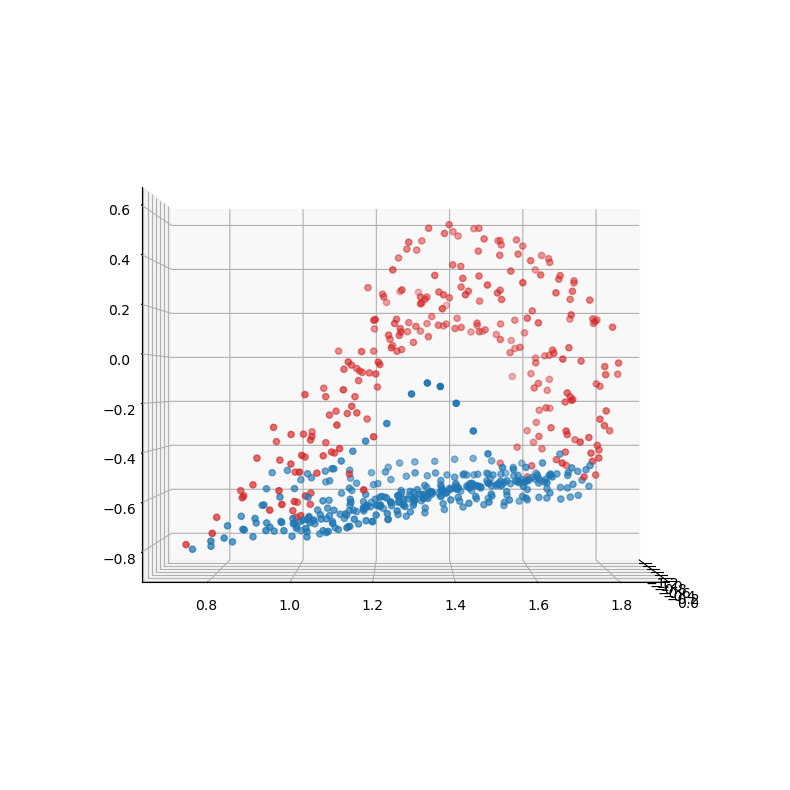

In [466]:
np.random.seed(44)
boutnum = np.random.choice(walking_df['walking_bout_number'].unique())
check = walking_df['walking_bout_number'] == 2156

leg = 'L1'

X = rotation_matrix(walking_df.loc[check], 0, -0.4, 0, leg)
#X = walking_df.loc[check, ['L3E_x', 'L3E_y', 'L3E_z']].to_numpy()

leg_velo = (np.sqrt(np.diff(X.T[0])**2 +\
                                np.diff(X.T[1])**2 +\
                                np.diff(X.T[2])**2) \
                       )/dt

leg_norm_y = X.T[1] - walking_df.loc[check, leg+'A_y'].values
#leg_norm_z = X.T[2] - df.loc[check,'head-thorax_z'].values
leg_velo[np.diff(leg_norm_y)<0] = -leg_velo[np.diff(leg_norm_y)<0]

s=0.5
leg_smoothed_velo = gaussian_filter1d(leg_velo, s)
leg_smoothed_velo = np.insert(leg_smoothed_velo, 0, leg_smoothed_velo[0])

# velo_thresh = 5 #L1
velo_thresh = 5
lower_velo_thresh = -35

# determine swing and stance based on velocity threshold
swing_stance = np.zeros(len(leg_smoothed_velo))
swing_stance[np.where(leg_smoothed_velo <= velo_thresh)[0]] = 1
swing_stance[np.where(leg_smoothed_velo > velo_thresh)[0]] = 0
swing_stance[np.where(leg_smoothed_velo <= lower_velo_thresh)[0]] = 0

# remove discrete events
for i in [3,4,5,3]:
    for j in range(len(swing_stance)-(i-1)):
        if swing_stance[j] == swing_stance[j+(i-1)] and swing_stance[j+1] != swing_stance[j] and np.all(swing_stance[j+1:j+(i-1)]== swing_stance[j+1]):
            swing_stance[j+1:j+(i-1)] = swing_stance[j]
    
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X.T[0], X.T[1], X.T[2], c=walking_df.loc[check, leg+'_swing_stance'], cmap=ListedColormap(['tab:blue','tab:red']))
#ax.scatter(X.T[0], X.T[1], X.T[2], c=swing_stance, cmap=ListedColormap(['tab:blue','tab:red']))
ax.view_init(0,0,0)

### Define finalized swing/stance classifier

In [9]:
def velo_swing_stance(df, parse_by='walking_bout_number', legs=['L1','R1','L2','R2','L3','R3'], velo_thresh=0, lower_velo_thresh=-35, dt=1/300):
    for leg in legs:
        total_step_num = 0
        for bout in tqdm(valid(df[parse_by].unique())):
            check = df[parse_by] == bout
            
            if '1' in leg: # apply rotation matrix to front legs
                rot_mat = rotation_matrix(df.loc[check], 0, -0.4, 0, leg)
                df.loc[check, leg+'E_x'] = rot_mat.T[0]
                df.loc[check, leg+'E_y'] = rot_mat.T[1]
                df.loc[check, leg+'E_z'] = rot_mat.T[2]
        
            # calculate leg tip velocity relative to neck connective point
            leg_velo = (np.sqrt(np.diff(df.loc[check, leg+'E_x'])**2 +\
                                np.diff(df.loc[check, leg+'E_y'])**2 +\
                                np.diff(df.loc[check, leg+'E_z'])**2) \
                       )/dt
            leg_norm_y = df.loc[check,leg+'E_y'].values - df.loc[check,'head-thorax_y'].values
            leg_velo[np.diff(leg_norm_y)<0] = -leg_velo[np.diff(leg_norm_y)<0]
        
            s=0.5 # smoothing parameter
            leg_smoothed_velo = gaussian_filter1d(leg_velo, s)
            df.loc[check, leg+'_smoothed_velo'] = np.insert(leg_smoothed_velo, 0, leg_smoothed_velo[0])
            
            # determine swing and stance based on velocity threshold
            swing = (df[leg+'_smoothed_velo'] > velo_thresh) | (df[leg+'_smoothed_velo'] <= lower_velo_thresh)
            stance = df[leg+'_smoothed_velo'] <= velo_thresh
            df.loc[check & swing, leg+'_swing_stance_v2'] = 0
            df.loc[check & stance, leg+'_swing_stance_v2'] = 1
            
            swing_stance = df.loc[check, leg+'_swing_stance_v2'].to_numpy()
            for i in [3,4,5,3]:
                for j in range(len(swing_stance)-(i-1)):
                    if swing_stance[j] == swing_stance[j+(i-1)] and swing_stance[j+1] != swing_stance[j] and np.all(swing_stance[j+1:j+(i-1)]== swing_stance[j+1]):
                        swing_stance[j+1:j+(i-1)] = swing_stance[j]
            df.loc[check, leg+'_swing_stance_v2'] = swing_stance
            
            # Initialize step number and previous value variables
            prev = df.loc[check, leg+'_swing_stance_v2'].iloc[0]
            step_num = 0 if prev == 0 else 1

            # Create a list to store step numbers
            step_num_arr = [step_num]

            # Iterate through the DataFrame and assign step numbers for the bout
            for cur in df.loc[check, leg+'_swing_stance_v2'].iloc[1:]:
                #print(prev)
                if prev == 0 and cur == 1:
                    step_num += 1

                step_num_arr.append(step_num)
                prev = cur
            step_num_arr = np.array(step_num_arr)
        
            # Assign the step numbers as a new column
            df.loc[check, leg+'_bout_step_num'] = step_num_arr
            
            # Keep track of step start and end indices
            min_max = df.loc[check].groupby(f'{leg}_bout_step_num').index.agg(['min', 'max'])
            for step in min_max.index:
                is_step = df[leg+'_bout_step_num'] == step #steps are 1 indexed, iterator is 0 indexed
                df.loc[check & is_step, leg+'_bout_step_start'] = min_max['min'][step]
                df.loc[check & is_step, leg+'_bout_step_end'] = min_max['max'][step]
                                  
    return df

In [10]:
walking_df = velo_swing_stance(walking_df)

100%|████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 190.97it/s]


In [11]:
# count number of steps in each leg (prior to filtering on steps)
legs = ['L1','R1','L2','R2','L3','R3']
walking_df.groupby('walking_bout_number')[[leg+'_bout_step_num' for leg in legs]].max().sum()

L1_bout_step_num    1263.0
R1_bout_step_num    1339.0
L2_bout_step_num    1298.0
R2_bout_step_num    1271.0
L3_bout_step_num    1285.0
R3_bout_step_num    1303.0
dtype: float64

### Plot swing/stance raster and 3D step trajectories for an example bout

In [327]:
# look at bout average velocities, pick one for plotting below
bout_stats = walking_df.groupby(['walking_bout_number'])[['fictrac_delta_rot_lab_y_mms', 'fictrac_delta_rot_lab_z_deg/s']].agg(['mean', 'count'])
bout_stats.sort_values(('fictrac_delta_rot_lab_z_deg/s', 'mean'))

fictrac_delta_rot_lab_y_mms        \
                                           mean count   
walking_bout_number                                     
2371.0                                 9.403257   349   
3494.0                                 9.542627    97   
1434.0                                12.297484    61   
3689.0                                 6.210285    61   
1302.0                                17.642221   253   
2237.0                                 6.000388    73   
2216.0                                13.100797    61   
2961.0                                 9.047521    97   
3546.0                                14.481730   109   
374.0                                 13.311485   481   
1349.0                                13.427606   109   
2541.0                                12.038278   361   
2755.0                                13.534066   169   
2373.0                                15.128693   157   
950.0                                 14.040361   313   
639.0                                  8.753239   121   
2479.0                                13.776967    97   
2774.0                                10.234078   145   
965.0                                 13.810253   193   
3233.0                                11.640282   133   
1525.0                                18.400489    61   
2367.0                                15.358317   109   
3219.0                                14.487078   385   
3628.0                                16.925741    85   
1526.0                                15.613072    73   
1443.0                                12.601176   121   
2496.0                                15.354765   193   
2929.0                                10.819250   217   
144.0                                  9.469990    73   
2846.0                                 5.185053    85   
1563.0                                14.319281    97   
1623.0                                18.081776    61   
3481.0                                12.528995   145   
3257.0                                13.047593   157   
3118.0                                10.030908   325   
2964.0                                 7.495541    85   
1516.0                                14.120225    97   
2030.0                                10.534091    85   
1802.0                                12.840636    61   
2029.0                                10.282596   265   
1426.0                                18.496920   157   
2617.0                                13.260015    61   
1970.0                                10.821335   301   
3275.0                                14.417307    97   
3717.0                                 7.276758   373   
2236.0                                18.296366   181   
2436.0                                 8.660884   145   
2469.0                                12.013908   145   
2822.0                                 7.054644    97   
3506.0                                11.450724   133   
2747.0                                14.051207    85   
1304.0                                16.915095    85   
2064.0                                15.335594    85   
2569.0                                10.522336    97   
3090.0                                10.004891    85   
1475.0                                15.390462   217   
2793.0                                 7.590262    85   
3128.0                                 9.360068   229   
1511.0                                 9.357789    73   
3634.0                                18.824478    85   
1506.0                                11.582026    85   
1818.0                                13.065549   265   
3167.0                                13.083131   265   
1891.0                                10.009227   241   
2972.0                                 6.156773    61   
2243.0                                13.495830    61   
3322.0                                 9.956687    73   
2167.0                        

In [33]:
pd.options.display.max_rows = 600
example_bout = walking_df['walking_bout_number'] == 1468
swing_stance_cols = [col for col in walking_df.columns if '_swing_stance_v2' in col]
# phase_cols = [col for col in walking_df.columns if '_step_phase' in col]
# swing_stance_cols.extend(phase_cols)
# swing_stance_cols.extend(['fnum', 'fullfile'])
swing_stance_mat = walking_df.loc[example_bout, swing_stance_cols].dropna()

bout_swing_stance = swing_stance_mat[['R1_swing_stance_v2', 'R2_swing_stance_v2', 'R3_swing_stance_v2',
                                      'L1_swing_stance_v2', 'L2_swing_stance_v2', 'L3_swing_stance_v2']].T.to_numpy()
swing_stance_mat

,L1_swing_stance_v2,R1_swing_stance_v2,L2_swing_stance_v2,R2_swing_stance_v2,L3_swing_stance_v2,R3_swing_stance_v2
31900,0.0,1.0,1.0,0.0,0.0,1.0
31901,0.0,1.0,1.0,0.0,0.0,1.0
31902,0.0,1.0,1.0,0.0,0.0,1.0
31903,0.0,1.0,1.0,1.0,0.0,1.0
31904,0.0,1.0,1.0,1.0,0.0,0.0
31905,0.0,1.0,1.0,1.0,0.0,0.0
31906,1.0,1.0,0.0,1.0,1.0,0.0
31907,1.0,1.0,0.0,1.0,1.0,0.0
31908,1.0,0.0,0.0,1.0,1.0,0.0
31909,1.0,0.0,0.0,1.0,1.0,0.0


In [35]:
walking_df.loc[example_bout, ['fnum', 'fullfile']]

,fnum,fullfile
31900,264,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31901,265,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31902,266,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31903,267,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31904,268,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31905,269,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31906,270,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31907,271,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31908,272,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...
31909,273,9.19.23|Fly 5_0|09192023_fly5_0 R8C2 str-cw-0...


In [335]:
fly_body_len_mm = walking_df.loc[example_bout, 'body_len_mm'].iloc[0]
bout_avg_speed = walking_df.loc[example_bout, 'fictrac_delta_rot_lab_y_mms'].mean()
bout_avg_speed / fly_body_len_mm

9.11433943896451

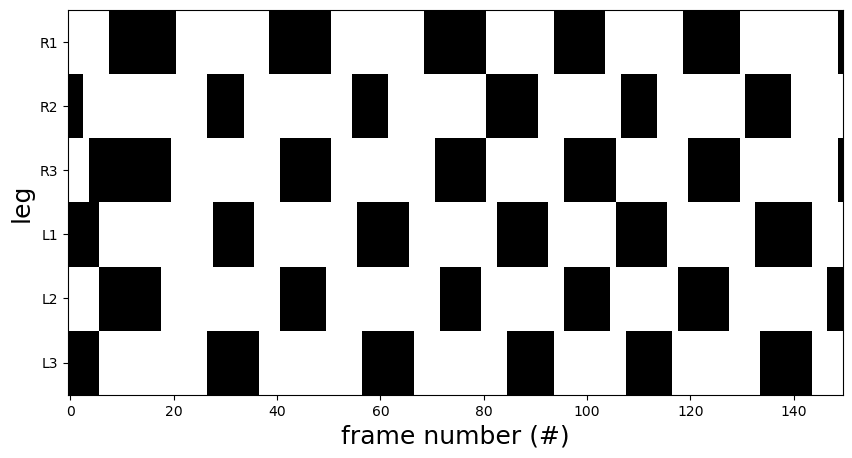

In [364]:
fig = plt.figure(1, figsize=[10,5])
plt.xlabel('frame number (#)', fontsize = 18)
plt.ylabel('leg', fontsize = 18)
labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
axes = plt.gca()
axes.set_yticks(np.arange(0, 6, 1))
axes.set_yticklabels(labels)
plt.imshow(bout_swing_stance[:,:-7], interpolation = 'none', cmap = 'gray',aspect='auto')
fig.savefig(figure_dir + f'swing_stance_ex_{date.today()}.png', dpi = 300)
fig.savefig(figure_dir + f'swing_stance_ex_{date.today()}.svg', dpi = 300)

### Calculate body lengths and filter steps

In [12]:
%matplotlib inline
#bout_nums = valid(walking_df['walking_bout_number'].unique())
FPS = 300.0

step_freq = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
             'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

swing_dur = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
             'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

stance_dur = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
             'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

swing_dist = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
             'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

stance_dist = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
             'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

step_dist = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
             'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

speed = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
         'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

flynum = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
         'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

speed_bin = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
             'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

body_lens = []


legs = ['L1', 'L2', 'L3', 'R1', 'R2', 'R3']

good_steps = {'L1':np.array([]),'L2':np.array([]),'L3':np.array([]),
              'R1':np.array([]),'R2':np.array([]),'R3':np.array([])}

walking_df['body_len_mm'] = np.nan


for flyid in tqdm(walking_df['flyid'].unique()):
    fly = walking_df[walking_df['flyid'] == flyid]
    #print(fly.shape)
    body_points = {'x':[], 'y':[], 'z':[]}
    body_points['x'].append(fly[f'abdomen-tip_x'].median())
    body_points['x'].append(fly[f'thorax-abdomen_x'].median())
    body_points['x'].append(np.median([fly[f'l-eye-t_x'].min(), fly[f'r-eye-t_x'].max()]))
    
    body_points['y'].append(fly[f'abdomen-tip_y'].mean())
    body_points['y'].append(fly[f'thorax-abdomen_y'].mean())
    body_points['y'].append(np.amax([fly[f'l-eye-t_y'].max(), fly[f'r-eye-t_y'].max()]))
    
    body_points['z'].append(fly[f'abdomen-tip_z'].mean())
    body_points['z'].append(fly[f'thorax-abdomen_z'].mean())
    body_points['z'].append(np.mean([fly[f'l-eye-t_z'].mean(), fly[f'r-eye-t_z'].mean()]))
    
    coxa_points = {'x':[], 'y':[], 'z':[]}
    coxa_points['x'].append(fly['L1A_x'].mean())
    coxa_points['x'].append(fly['L1B_x'].mean())
    coxa_points['y'].append(fly['L1A_y'].mean())
    coxa_points['y'].append(fly['L1B_y'].mean())
    coxa_points['z'].append(fly['L1A_z'].mean())
    coxa_points['z'].append(fly['L1B_z'].mean())
    
    coxa_len_arb = np.sqrt((coxa_points['x'][1] - coxa_points['x'][0])**2 + 
                           (coxa_points['y'][1] - coxa_points['y'][0])**2 + 
                           (coxa_points['z'][1] - coxa_points['z'][0])**2)
    
    coxa_len_mm = 0.261
    
    body_len_arb = np.sqrt((body_points['x'][2] - body_points['x'][1])**2 + 
                           (body_points['y'][2] - body_points['y'][1])**2 + 
                           (body_points['z'][2] - body_points['z'][1])**2)
    
    body_len_arb += np.sqrt((body_points['x'][1] - body_points['x'][0])**2 + 
                           (body_points['y'][1] - body_points['y'][0])**2 + 
                           (body_points['z'][1] - body_points['z'][0])**2)
    
    body_len_mm = (coxa_len_mm / coxa_len_arb) * body_len_arb
    
    walking_df.loc[walking_df['flyid'] == flyid, 'body_len_mm'] = body_len_mm
    fly['body_len_mm'] = body_len_mm
    print(body_len_mm)
    
    bout_nums = fly['walking_bout_number'].unique() 
    for leg in legs:
        for bout_num in bout_nums:
            bout = fly[fly['walking_bout_number'] == bout_num] 
            
            steps = np.sort(valid(bout[f'{leg}_bout_step_num'].unique()))

            bout_swing_dur = np.array([])
            bout_stance_dur = np.array([])
            bout_speed = np.array([])

            for step_num in steps[1:-1]:
                
                step = bout[bout[f'{leg}_bout_step_num'] == step_num]
                where_swing = np.where(step[f'{leg}_swing_stance_v2'].to_numpy() == 0)[-1]
                where_stance = np.where(step[f'{leg}_swing_stance_v2'].to_numpy() == 1)[-1]
        
                step_len = np.sum(np.hypot(np.diff(step['fictrac_int_x_mm']), \
                                           np.diff(step['fictrac_int_y_mm']))) / body_len_mm
            
                step_speed = np.nanmean(step['fictrac_delta_rot_lab_y_mms']) / np.nanmean(step['body_len_mm'])

                if (0.02 <= where_swing.size / FPS <= 0.075) and (5 <= 1/(len(step)/FPS) <= 20) and step_speed > 0 and where_stance.size / FPS > 0.02 and step_len > 0:   
                    good_steps[leg] = np.append(good_steps[leg], step[f'{leg}_bout_step_num'].iloc[0])
                    flynum[leg] = np.append(flynum[leg], step['flynum'].iloc[0])
                    
                    step_freq[leg] = np.append(step_freq[leg], 1/(len(step)/FPS))
                    swing_dur[leg] = np.append(swing_dur[leg], where_swing.size / FPS)
                    stance_dur[leg] = np.append(stance_dur[leg], where_stance.size / FPS)
                    speed[leg] = np.append(speed[leg], step_speed)
                    
                    if step_speed < 6:
                        speed_bin[leg] = np.append(speed_bin[leg], 0)
                    elif 6 <= step_speed < 10:
                        speed_bin[leg] = np.append(speed_bin[leg], 1)
                    else:
                        speed_bin[leg] = np.append(speed_bin[leg], 2)

                    swing_x = step[f'{leg}E_x'].iloc[where_swing] 
                    swing_y = step[f'{leg}E_y'].iloc[where_swing] 
                    swing_z = step[f'{leg}E_z'].iloc[where_swing] 
                    swing_int_path = np.sum(np.hypot(np.diff(swing_x), np.diff(swing_y), np.diff(swing_z))) / body_len_arb
                    swing_dist[leg] = np.append(swing_dist[leg], swing_int_path)

                    stance_x = step[f'{leg}E_x'].iloc[where_stance] 
                    stance_y = step[f'{leg}E_y'].iloc[where_stance] 
                    stance_z = step[f'{leg}E_z'].iloc[where_stance]
                    stance_int_path = np.sum(np.hypot(np.diff(stance_x), np.diff(stance_y), np.diff(stance_z))) / body_len_arb
                    stance_dist[leg] = np.append(stance_dist[leg], stance_int_path)

                    step_dist[leg] = np.append(step_dist[leg], step_len)

speed_bin['L2'] += 3 
speed_bin['R2'] += 3
speed_bin['L3'] += 6
speed_bin['R3'] += 6
#print(step_freq['L1'].shape, swing_dur['L1'].shape, stance_dur['L1'].shape, swing_dist['L1'].shape, stance_dist['L1'].shape, speed['L1'].shape)

  0%|                                                                            | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_1097057/1879685197.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fly['body_len_mm'] = body_len_mm
  8%|█████▋                                                              | 1/12 [00:00<00:01,  7.23it/s]

1.8636226745003672
1.8427508859018242


 17%|███████████▎                                                        | 2/12 [00:00<00:03,  2.56it/s]

1.7905615817785554


 25%|█████████████████                                                   | 3/12 [00:00<00:02,  3.24it/s]

2.0072515004964413


 33%|██████████████████████▋                                             | 4/12 [00:01<00:03,  2.48it/s]

1.7603312935436541


 42%|████████████████████████████▎                                       | 5/12 [00:01<00:02,  2.58it/s]

1.6692126940812246


 50%|██████████████████████████████████                                  | 6/12 [00:02<00:02,  2.52it/s]

1.9877834410354547


 67%|█████████████████████████████████████████████▎                      | 8/12 [00:02<00:01,  3.41it/s]

1.811059205220145
1.7487300710725258


 75%|███████████████████████████████████████████████████                 | 9/12 [00:02<00:00,  3.38it/s]

1.807519613060357


 92%|█████████████████████████████████████████████████████████████▍     | 11/12 [00:03<00:00,  2.92it/s]

1.8636589135486803
1.72673192842122


100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.87it/s]


In [342]:
# save the data
speed_arr = []
step_freq_arr = []
stance_dur_arr = []
swing_dur_arr = []
step_len_arr = []

for leg in ['L1', 'R1', 'L2', 'R2', 'L3', 'R3']:
    speed_arr.extend(speed[leg])
    step_freq_arr.extend(step_freq[leg])
    stance_dur_arr.extend(stance_dur[leg])
    swing_dur_arr.extend(swing_dur[leg])
    step_len_arr.extend(step_dist[leg])
    
kin_params = np.vstack([np.array(speed_arr), np.array(step_freq_arr), np.array(stance_dur_arr),\
                        np.array(swing_dur_arr), np.array(step_len_arr)])

print(kin_params.shape)

np.save(f'treadmill_pape/npy_files/ball/kin_params_ball_{date.today()}.npy', kin_params)

(5, 5149)


In [343]:
# save the data grouped into speed bins
t1_speed_bins = np.append(speed_bin['L1'], speed_bin['R1'])
t2_speed_bins = np.append(speed_bin['L2'], speed_bin['R2'])
t3_speed_bins = np.append(speed_bin['L3'], speed_bin['R3'])

speed_bin_arr = np.append(t1_speed_bins, t2_speed_bins)
speed_bin_arr = np.append(speed_bin_arr, t3_speed_bins)
speed_bin_arr.shape

metrics = [step_freq, swing_dur, stance_dur, step_dist]
filenames = ['step_frequency', 'swing_duration', 'stance_duration', 'step_length']
for i in range(len(metrics)):
    t1_metric = np.append(metrics[i]['L1'], metrics[i]['R1'])
    t2_metric = np.append(metrics[i]['L2'], metrics[i]['R2'])
    t3_metric = np.append(metrics[i]['L3'], metrics[i]['R3'])
    
    metric_arr = np.append(t1_metric, t2_metric)
    metric_arr = np.append(metric_arr, t3_metric)
    
    save_arr = np.vstack([metric_arr, speed_bin_arr])
    np.save(f'treadmill_pape/npy_files/ball/{filenames[i]}_ball_{date.today()}.npy', save_arr)

### Plot intralimb kinematics

In [344]:
freq_distr = []
swing_duration_distr = []
stance_duration_distr = []
dist_distr = []

# freq_arr = np.array([[],[]])
# swing_dur_arr = np.array([[],[]])
# stance_dur_arr = np.array([[],[]])
# dist_dur_arr = np.array([[],[]])

leg = 1
for leg in [1,2,3]:
    speeds = np.append(speed[f'L{leg}'], speed[f'R{leg}']) 
    freq = np.append(step_freq[f'L{leg}'], step_freq[f'R{leg}'])
    dist = np.append(step_dist[f'L{leg}'], step_dist[f'R{leg}']) 
    swing_t = np.append(swing_dur[f'L{leg}'], swing_dur[f'R{leg}'])
    stance_t = np.append(stance_dur[f'L{leg}'], stance_dur[f'R{leg}'])
    flies = np.append(flynum[f'L{leg}'], flynum[f'R{leg}'])

    freq_distr.append(np.vstack((flies, speeds, freq)))
    swing_duration_distr.append(np.vstack((flies, speeds, swing_t)))
    stance_duration_distr.append(np.vstack((flies, speeds, stance_t)))
    dist_distr.append(np.vstack((flies, speeds, dist)))
    
    

#### Speed binned averages

In [346]:
import seaborn as sea
def plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val):
    # plot parameters
    leg_colors = ['tab:blue', 'tab:orange', 'tab:green']
    # plot 1D metrics
    g = sea.JointGrid()
    # scatter
    if plot_scatter:
        for leg in range(3):
            if add_offset:
                y_offset = np.array([1,-1,0])[leg] * offset_val
                sea.scatterplot(x=plot_metric[leg][1,:], y=plot_metric[leg][2,:]+y_offset, color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint)
            else:
                sea.scatterplot(x=plot_metric[leg][1,:], y=plot_metric[leg][2,:], color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint)

    # average speed bins instead of fitting
    bin_size = 2
    speed_start = 2#2 # BL/s
    speed_end = 14#15.5 # BL/s
    bin_edges = np.arange(speed_start, speed_end, bin_size)
    ave_fits = np.zeros((3, len(bin_edges), 2)) # leg pairs, number of bins, mean + 95% confidence
    for j in range(3):
        for i in range(len(bin_edges)):
            bin_data = plot_metric[j][2, np.logical_and(plot_metric[j][1,:] >= bin_edges[i], plot_metric[j][1,:] < bin_edges[i] + bin_size)]
            ave_fits[j,i,0] = np.mean(bin_data) # mean
            ave_fits[j,i,1] = (1.96 * np.std(bin_data))/np.sqrt(len(bin_data)) # 95% confidence
        # plot the mean line
        sea.lineplot(x=bin_edges+(bin_size/2), y=ave_fits[j,:,0], color = leg_colors[j], linewidth = 2.5, alpha =1, ax=g.ax_joint)
        #sea.lineplot(x=bin_edges+(bin_size/2), y=ave_fits[j,:,0], color = leg_colors[j], marker = 'o', markersize=6 ,markeredgecolor=leg_colors[j],linewidth = 2.5, alpha =1, ax=g.ax_joint)
    # kde propability - speed and metric
    for leg in range(3):
        sea.kdeplot(x=plot_metric[leg][1,:], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_x, bw_adjust = 2.5)
        sea.kdeplot(y=plot_metric[leg][2,:], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_y, bw_adjust = 2.5)
    # legend and plotting parameters
     # global fits
    n_steps = np.zeros(3)
    for leg in range(3):
        n_steps[leg] = len(plot_metric[leg][1,:])
    legend_text = ['Front Legs (steps = '+str(int(n_steps[0]))+ ')', 'Middle Legs (steps = '+str(int(n_steps[1]))+')', 'Hind Legs (steps = '+str(int(n_steps[2]))+ ')']
    g.ax_joint.legend(legend_text, fontsize = 12, bbox_to_anchor=(1.0, 1.5))
    g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
    g.ax_joint.tick_params(axis='both', labelsize=14)
    g.ax_joint.set_xlim([0,20])
    g.ax_joint.set_ylim([ylim[0],ylim[1]])
    plt.tight_layout()
    plt.show()
    
    figure_dir = 'treadmill_pape/ball_figs/'
    g.savefig(figure_dir + fig_name+f'_offset_{date.today()}.png', dpi = 200)
    g.savefig(figure_dir + fig_name+f'_offset_{date.today()}.pdf', dpi = 200)
    g.savefig(figure_dir + fig_name+f'_offset_{date.today()}.svg', dpi = 200)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/tmp/ipykernel_1017229/778936600.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


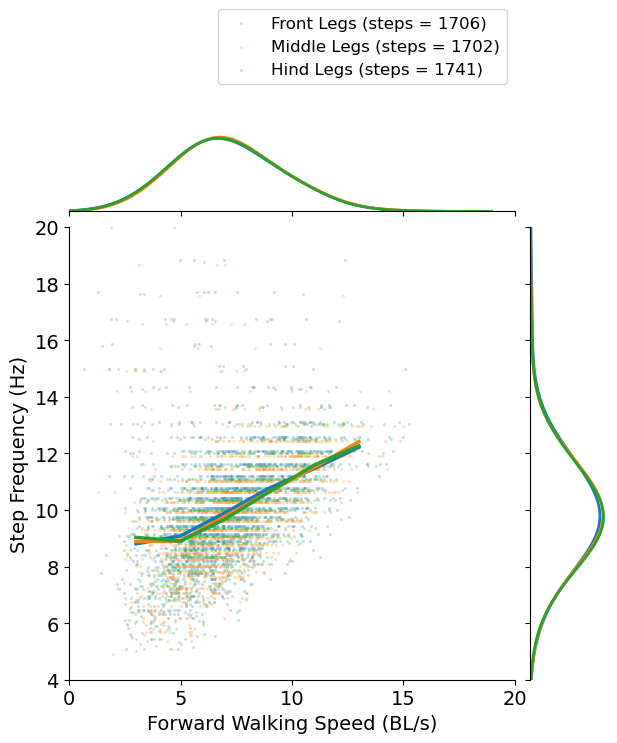

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [347]:
# plot_metric = step_freq_distributions
plot_metric = freq_distr
ylabel_name = 'Step Frequency (Hz)'
fig_name = 'Step_freq_ball'
p_coeff = 1
plot_scatter = True
ylim = [4,20]
add_offset = True
offset_val = 0.075
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/tmp/ipykernel_1017229/778936600.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


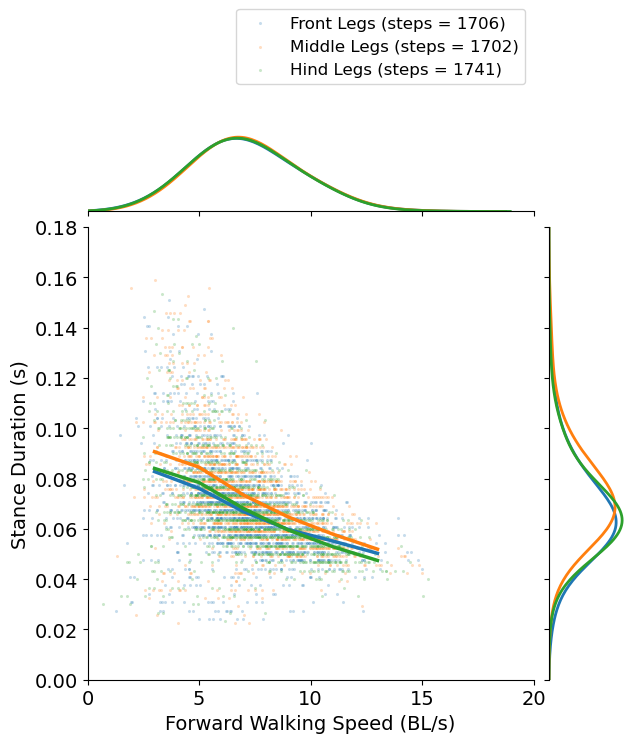

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [348]:
# plot_metric = step_freq_distributions
plot_metric = stance_duration_distr
ylabel_name = 'Stance Duration (s)'
fig_name = 'Stance_duration_ball'
p_coeff = 2
plot_scatter = True
ylim = [0, 0.18]
add_offset = True
offset_val = 0.00085
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/tmp/ipykernel_1017229/778936600.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


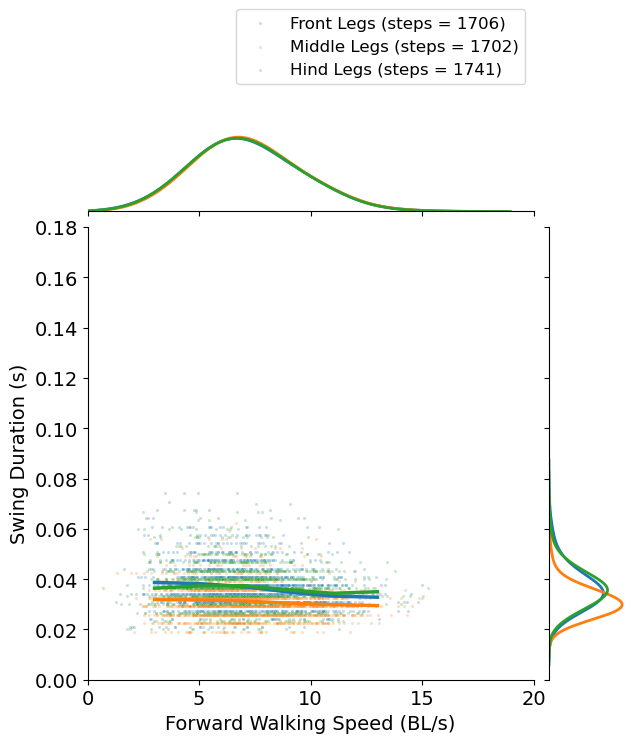

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [349]:
# plot_metric = step_freq_distributions
plot_metric = swing_duration_distr
ylabel_name = 'Swing Duration (s)'
fig_name = 'Swing_duration_ball'
p_coeff = 1
plot_scatter = True
ylim = [0, 0.18]
add_offset = True
offset_val = 0.00085
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/tmp/ipykernel_1017229/778936600.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


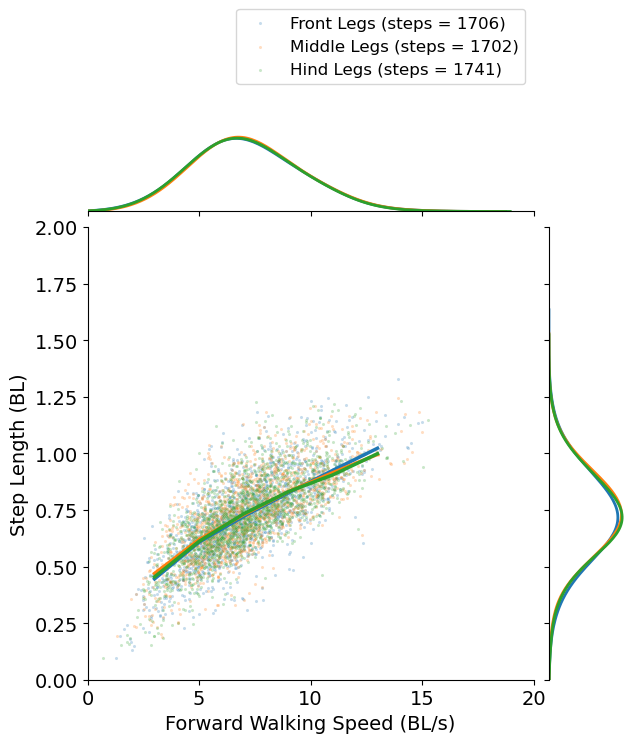

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [350]:
plot_metric = dist_distr
ylabel_name = 'Step Length (BL)'
fig_name = 'step_distance_ball'
p_coeff = 1
plot_scatter = True
ylim = [0, 2]
add_offset = False
offset_val = 0.0004
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val)

### Create heatmap of intralimb kinematic summary statistics

### Phase polar plots

In [13]:
bouts = valid(walking_df['walking_bout_number'].unique())
phase_store = [[],[],[],[],[]]
bout_speeds = [[],[],[],[],[]]
flies = [[],[],[],[],[]]
identifier = [[],[],[],[],[]]
for bout_num in bouts:
    legs = ['L1', 'R1', 'L2', 'R2', 'L3', 'R3']
    check = walking_df['walking_bout_number'] == bout_num
    bout = walking_df[check]
    #bout = bout.reset_index()
    fwd_speed = bout['fictrac_delta_rot_lab_y_mms'].mean()
    rot_speed = np.abs(bout['fictrac_delta_rot_lab_z_deg/s'].mean())
    #if (5 < fwd_speed <= 35) and (len(bout) >= 60) and (np.abs(rot_speed) < 15):
    #bout_speeds.append(bout['fictrac_delta_rot_lab_y_mms'])
    stance_start = []
    
    for leg in legs:
        stance_start.append(np.unique(valid(bout[f'{leg}_bout_step_start'].values)))
    # For a given walking bout, compute the relative phase
    # Extract L1 reference leg step starts
    L1_stance_start = stance_start[0]
    if len(L1_stance_start) > 1:
        for L1_step in range(len(L1_stance_start)-1):
            for leg in range(len(stance_start) -1):
                stance_index = stance_start[leg+1][np.logical_and(stance_start[leg+1] >= L1_stance_start[L1_step], stance_start[leg+1] < L1_stance_start[L1_step+1])]
                if len(stance_index) > 0: # make sure there is a match - only consider the first index
                    relative_phase = (stance_index[0]-L1_stance_start[L1_step])/(L1_stance_start[L1_step+1]-L1_stance_start[L1_step])
                    # store relative phase information
                    step = bout[bout['L1_bout_step_start'] == L1_stance_start[L1_step]]
                    phase_store[leg].append(relative_phase)
                    bout_speeds[leg].append(step['fictrac_delta_rot_lab_y_mms'].mean() / step['body_len_mm'].iloc[0])
                    flies[leg].append(bout['flynum'].iloc[0])
                    identifier[leg].append(str(int(bout_num))+ '_'+str(int(L1_stance_start[L1_step])))

In [15]:
def estimate_ang_stats(var):
    mean_angle = np.arctan2(np.nanmean(np.sin(var)), np.nanmean(np.cos(var)))
    angular_dispersion = np.sqrt(np.nanmean(np.sin(var))**2 + np.nanmean(np.cos(var))**2) # 0: uniform, 1: concetrated in one directtion
    return mean_angle, angular_dispersion

In [16]:
# transform phase values to between -np.pi to np.pi
def transform_half_polar(var):
    var[var>np.pi] = var[var>np.pi] - (2*np.pi)
    return var

In [17]:
def full_distribution_transform_polar(var):
    var[var<0] = np.pi + np.abs(-np.pi - var[var<0])
    return var

In [18]:
def compute_inphase_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(-np.pi, np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

In [19]:
def compute_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(0.0,2*np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

In [20]:
# function that transforms that space from 0 to pi to 0 to 2pi
def transform_polar(org_val):
    if org_val < 0: # only need to transform negative values to extend the space to 2pi
        transformed_val = np.pi + np.abs(-np.pi - org_val)
    else: 
        transformed_val = org_val
        
    return transformed_val

In [21]:
legs = ['R1', 'L2', 'R2', 'L3', 'R3']
for i in range(len(phase_store)):
    np.save(f'treadmill_pape/npy_files/ball/{legs[i]}_relative_phase_ball_{date.today()}.npy', phase_store[i])

/tmp/ipykernel_1097057/2883484999.py:2: RuntimeWarning: Mean of empty slice
  mean_angle = np.arctan2(np.nanmean(np.sin(var)), np.nanmean(np.cos(var)))
/tmp/ipykernel_1097057/2883484999.py:3: RuntimeWarning: Mean of empty slice
  angular_dispersion = np.sqrt(np.nanmean(np.sin(var))**2 + np.nanmean(np.cos(var))**2) # 0: uniform, 1: concetrated in one directtion
/home/tuthill/mambaforge/envs/anipose/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_1097057/2883484999.py:2: RuntimeWarning: Mean of empty slice
  mean_angle = np.arctan2(np.nanmean(np.sin(var)), np.nanmean(np.cos(var)))
/tmp/ipykernel_1097057/2883484999.py:3: RuntimeWarning: Mean of empty slice
  angular_dispersion = np.sqrt(np.nanmean(np.sin(var))**2 + np.nanmean(np.cos(var))**2) # 0: uniform, 1: concetrated in one directtion
/home/tuthill/mambaforge/envs/anipose/lib/python3.9/site-packages/numpy/lib/histograms.py:906:

392.8
521.0
120.0


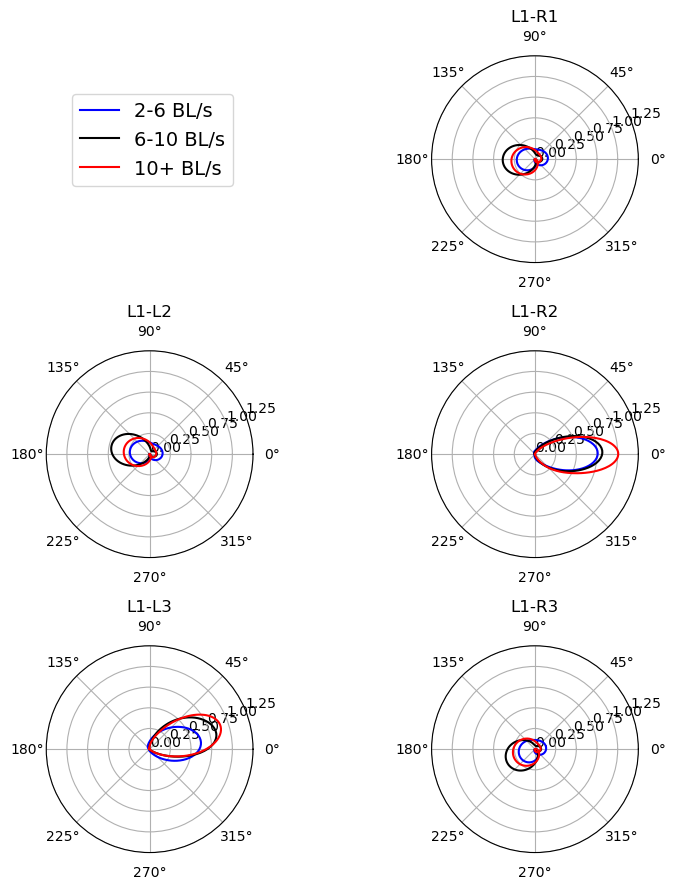

In [22]:
fig, ax = plt.subplots(3,2, subplot_kw={'projection': 'polar'}, figsize=(8,9), sharex=True, sharey=True)
labels = ['2-6 BL/s', '6-10 BL/s', '10+ BL/s']
comps = ['L1-R1', 'L1-L2', 'L1-R2', 'L1-L3', 'L1-R3']
Nbins = 15
slow_n = 0
med_n = 0
fast_n = 0
for i in range(len(phase_store)):
    slow_idxs = np.where((np.array(bout_speeds[i]) >= 2) & (np.array(bout_speeds[i]) < 6))[0]
    med_idxs = np.where((np.array(bout_speeds[i]) >= 6) & (np.array(bout_speeds[i]) < 10))[0]
    fast_idxs = np.where(np.array(bout_speeds[i]) >= 10)[0]
    
    slow_n += len(slow_idxs)
    med_n += len(med_idxs)
    fast_n += len(fast_idxs)
    
    k = 1 if 'R' in comps[i] else 0
    j = int(comps[i][-1]) - 1
    if j == 0 and k == 1:
        slowlab = labels[0]
        medlab = labels[1]
        fastlab = labels[2]
    else:
        slowlab = None
        medlab = None
        fastlab = None
    phase = np.array(phase_store[i]) * 2 * np.pi
    if i in [2,3]:
        phase[np.where(phase > np.pi)] = phase[np.where(phase > np.pi)] - (2*np.pi)
    sns.kdeplot(x=phase[slow_idxs], ax=ax[j,k], label=slowlab, color='blue', linewidth = 1.5, zorder=10, bw_adjust=2)
    sns.kdeplot(x=phase[med_idxs], ax=ax[j,k], label=medlab, color='black', linewidth = 1.5, zorder=10, bw_adjust=2)
    sns.kdeplot(x=phase[fast_idxs], ax=ax[j,k], label=fastlab, color='red', linewidth = 1.5, zorder=10, bw_adjust=2)
    bins = [slow_idxs, med_idxs, fast_idxs]
    colors = ['blue', 'k', 'red']
    c = 0
    for speed_bin in bins:
        for fly in np.unique(flies[i]):
            fly_idxs = np.where(np.array(flies[i])[speed_bin] == fly)
            #print(len(fly_idxs))
            slow_mean, _ = estimate_ang_stats(phase[speed_bin][fly_idxs])
            if i in [2,3]:
                # distribution
                fly_slow_dist = transform_half_polar(phase[speed_bin][fly_idxs])
                slow_prob, slow_bin_centers = compute_inphase_histogram(fly_slow_dist, Nbins)
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(slow_bin_centers, slow_prob, fill_value='extrapolate')
                interp_slow_prob =  f(slow_mean)
            else:
                slow_mean = transform_polar(slow_mean)
                # distribution
                slow_prob, slow_bin_centers = compute_histogram(phase[speed_bin][fly_idxs], Nbins)
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(slow_bin_centers, slow_prob, fill_value='extrapolate')
                interp_slow_prob =  f(slow_mean)
            #ax[j,k].plot(np.array([0, slow_mean]), np.array([0, interp_slow_prob]), color = colors[c], linewidth = 1, zorder=1, alpha = 0.5)
        c+=1

    ax[j,k].set_rticks(np.arange(0,1.26,0.25)) # kernel density
    ax[j,k].set_title(comps[i])
    ax[j,k].set_ylabel('')
    #ax[j,k].set_ylim([0,1.2])

slow_n /= 5
med_n /= 5
fast_n /= 5

print(slow_n)
print(med_n)
print(fast_n)

ax[0,0].axis('off')
fig.legend(bbox_to_anchor=(0.15,0.9), fontsize=14, loc='upper left')
plt.tight_layout()
# plt.show()
# plt.savefig('treadmill_pape/ball_figs/L1_relative_phase_distribution_ball.pdf', dpi=200)
# plt.savefig('treadmill_pape/ball_figs/L1_relative_phase_distribution_ball.png', dpi=200)
plt.savefig(f'treadmill_pape/ball_figs/L1_rel_phase_distr_ball_{date.today()}.svg', dpi=200)

#### Proportion of steps associated with tripod step order

In [28]:
# Determine Step order of the legs within a tripod
leg_order_classification = []

# Right Tripod Legs
r_same_vals = np.intersect1d(np.array(identifier[4]), np.intersect1d(np.array(identifier[0]), np.array(identifier[1])))
l1_r1_trial_vals = np.zeros(len(r_same_vals))
l1_l2_trial_vals = np.zeros(len(r_same_vals))
l1_r3_trial_vals = np.zeros(len(r_same_vals))

for i in range(len(r_same_vals)):
    # phase values for right tripod legs
    l1_r1_trial_vals[i] =  np.array(phase_store[0])[np.where(np.array(identifier[0])==r_same_vals[i])[0]]
    l1_l2_trial_vals[i] =  np.array(phase_store[1])[np.where(np.array(identifier[1])==r_same_vals[i])[0]]
    l1_r3_trial_vals[i] =  np.array(phase_store[4])[np.where(np.array(identifier[4])==r_same_vals[i])[0]]
    
# Classify step order into categories
for j in range(len(l1_r1_trial_vals)):
    if (l1_r1_trial_vals[j] > l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]):
        leg_order_classification.append(7)
    elif (l1_r1_trial_vals[j] > l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
        leg_order_classification.append(4)
    elif (l1_r1_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]):
        leg_order_classification.append(8)
    elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] < l1_r1_trial_vals[j]):
        leg_order_classification.append(9)
    elif (l1_l2_trial_vals[j] > l1_r1_trial_vals[j]) and (l1_r1_trial_vals[j] > l1_r3_trial_vals[j]):
        leg_order_classification.append(10)
    elif (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]):
        leg_order_classification.append(1)
    elif (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]) and (l1_r1_trial_vals[j] > l1_l2_trial_vals[j]):
        leg_order_classification.append(5)
    elif (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r1_trial_vals[j]):
        leg_order_classification.append(0)
    elif (l1_r1_trial_vals[j] == l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
        leg_order_classification.append(6)
    elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]):
        leg_order_classification.append(2)
    elif (l1_r1_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
        leg_order_classification.append(3)
    elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] == l1_r1_trial_vals[j]):
        leg_order_classification.append(11)

# Left Tripod Legs
l_same_vals = np.intersect1d(np.array(identifier[2]), np.array(identifier[3]))
l1_r2_trial_vals = np.zeros(len(l_same_vals))
l1_l3_trial_vals = np.zeros(len(l_same_vals))

for i in range(len(l_same_vals)):
    # phase values for right tripod legs
    l1_r2_trial_vals[i] =  np.array(phase_store[2])[np.where(np.array(identifier[2]) == l_same_vals[i])[0]]
    l1_l3_trial_vals[i] =  np.array(phase_store[3])[np.where(np.array(identifier[3]) == l_same_vals[i])[0]]
    
# correct for the wrap around
l1_r2_trial_vals[l1_r2_trial_vals >= 0.5] = l1_r2_trial_vals[l1_r2_trial_vals >= 0.5] -1
l1_l3_trial_vals[l1_l3_trial_vals >= 0.5] = l1_l3_trial_vals[l1_l3_trial_vals >= 0.5] -1

# Classify step order into categories
for j in range(len(l1_r2_trial_vals)):
    if (0 > l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]):
        leg_order_classification.append(7)
    elif (0 > l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]):
        leg_order_classification.append(4)
    elif (0 == l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]):
        leg_order_classification.append(8)
    elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] < 0): # front leg occurs last
        leg_order_classification.append(9)
    elif (l1_r2_trial_vals[j] > 0) and (0 > l1_l3_trial_vals[j]):
        leg_order_classification.append(10)
    elif (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
        leg_order_classification.append(1)
    elif (l1_l3_trial_vals[j] > 0) and (0 > l1_r2_trial_vals[j]):
        leg_order_classification.append(5)
    elif (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > 0):
        leg_order_classification.append(0)
    elif (0 == l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]):
        leg_order_classification.append(6)
    elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
        leg_order_classification.append(2)
    elif (0 == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
        leg_order_classification.append(3)
    elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] == 0):
        leg_order_classification.append(11)

# convert into an array
leg_order_classification = np.array(leg_order_classification)
print('Number of Steps = ', len(leg_order_classification))
# determine the proportion of each category represented
category_proportion = np.zeros(12)
for j in range(len(category_proportion)):
    category_proportion[j] = len(np.where(leg_order_classification == j)[0])/len(leg_order_classification)

Number of Steps =  1947


In [26]:
figure_dir = 'treadmill_pape/ball_figs/'

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

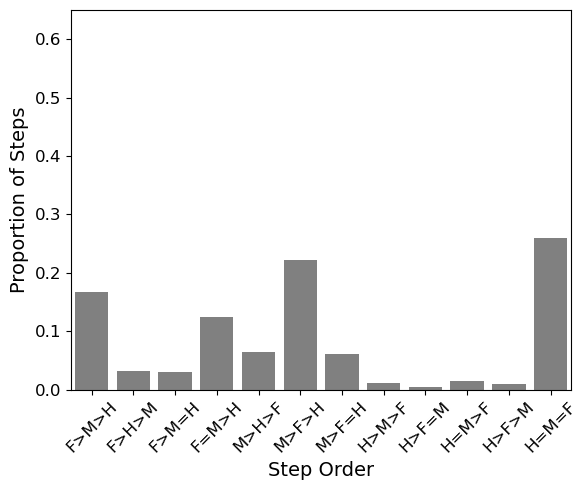

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [29]:
# Plot the proportion of each step type
cat_names = ['F>M>H', 'F>H>M', 'F>M=H','F=M>H' ,'M>H>F', 'M>F>H', 'M>F=H', 'H>M>F', 'H>F=M', 'H=M>F', 'H>F>M', 'H=M=F']
fig = plt.figure(1, figsize =  [6,5])
sns.barplot(x= np.arange(0,12), y = category_proportion, color = 'gray')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylim(0, 0.65)
plt.xticks(np.arange(0,12), cat_names, fontsize = 12, fontname = 'Arial', rotation = 45)
plt.ylabel('Proportion of Steps', fontsize = 14, fontname = 'Arial')
plt.xlabel('Step Order', fontsize = 14, fontname = 'Arial')
plt.tight_layout()
plt.show()
fig.savefig(figure_dir + f'step_order_ball_{date.today()}.png', dpi = 300)
fig.savefig(figure_dir + f'step_order_ball_{date.today()}.pdf', dpi = 300)
fig.savefig(figure_dir + f'step_order_ball_{date.today()}.svg', dpi = 300)

### Plot P(number of legs in stance)

In [357]:
#swing_stance = [col for col in walking_df.columns if '_swing_stance' in col]
swing_stance = ['L1_swing_stance_v2',
                'R1_swing_stance_v2',
                'L2_swing_stance_v2',
                'R2_swing_stance_v2',
                'L3_swing_stance_v2',
                'R3_swing_stance_v2']

In [358]:
fw_nlegs = np.sum(walking_df[swing_stance].dropna().reset_index(drop=True).to_numpy(), axis=1)

In [359]:
fw_vel = walking_df['fictrac_delta_rot_lab_y_mms'].iloc[walking_df[swing_stance].dropna().reset_index(drop=True).index].to_numpy()
body_lens = walking_df['body_len_mm'].iloc[walking_df[swing_stance].dropna().reset_index(drop=True).index].to_numpy()
fw_vel = fw_vel / body_lens

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

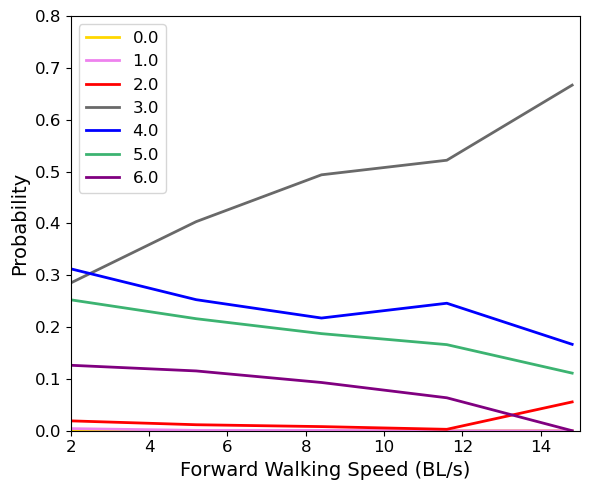

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [361]:
# edges of distributions
vel_bins = 6
# vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
vel_grid = np.linspace(2, 18, vel_bins)
vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)
nleg_cat = np.unique(fw_nlegs)
# compute probability distribution for each of the nleg categories
nleg_prob = np.zeros((len(nleg_cat), len(vel_center)))
for j in range(len(nleg_cat)):
    leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
    for i in range(len(vel_center)):
        nleg_vels = fw_vel[leg_idxs]
        nleg_prob[j,i] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
nleg_prob = nleg_prob/np.sum(nleg_prob, axis = 0)
# plot the probability of a certain number of legs in stance
fig = plt.figure(1, figsize = [6,5])
# plt.style.use('ggplot')
plt_colors = ['gold', 'violet', 'red', 'dimgray', 'blue', 'mediumseagreen', 'purple']
for j in range(nleg_prob.shape[0]):
    plt.plot(vel_center, nleg_prob[j,:], linewidth =2, color = plt_colors[j])
# axis properties
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xlabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Probability', fontsize = 14, fontname = 'Arial')
plt.xlim([2, 15])
plt.ylim([0, 0.8])
plt.legend(nleg_cat.astype(str), fontsize =12)
plt.grid(False)
plt.tight_layout()
plt.show()

figure_dir = 'treadmill_pape/ball_figs/'
fig.savefig(figure_dir + f'nleg_stance_prob_{date.today()}'+'.png', dpi = 200)
fig.savefig(figure_dir + f'nleg_stance_prob_{date.today()}'+'.pdf', dpi = 200)
fig.savefig(figure_dir + f'nleg_stance_prob_{date.today()}'+'.svg', dpi = 200)

['treadmill_pape/npy_files/ball/step_frequency_ball_2024-01-23.npy', 'treadmill_pape/npy_files/bowl/upsampled_step_frequency_FB_v4.npy', 'treadmill_pape/npy_files/treadmill/upsampled_step_frequency_LT.npy']
0.5365002618724493 0.718071828538931
0.585382133579726 0.3463897836593701
0.7275091626665923 0.42636462593722185
['treadmill_pape/npy_files/ball/stance_duration_ball_2024-01-23.npy', 'treadmill_pape/npy_files/bowl/upsampled_stance_duration_FB_v4.npy', 'treadmill_pape/npy_files/treadmill/upsampled_stance_duration_LT.npy']
0.699983738432011 0.4721673478796227
0.9049515426462333 0.7029430685396281
0.6467443777030251 0.3948986091313175
['treadmill_pape/npy_files/ball/swing_duration_ball_2024-01-23.npy', 'treadmill_pape/npy_files/bowl/upsampled_swing_duration_FB_v4.npy', 'treadmill_pape/npy_files/treadmill/upsampled_swing_duration_LT.npy']
1.34706174115958 0.4794865221846174
0.259065504625378 0.08471396675749172
1.3852424861897206 0.31648801869553606
['treadmill_pape/npy_files/ball/step_

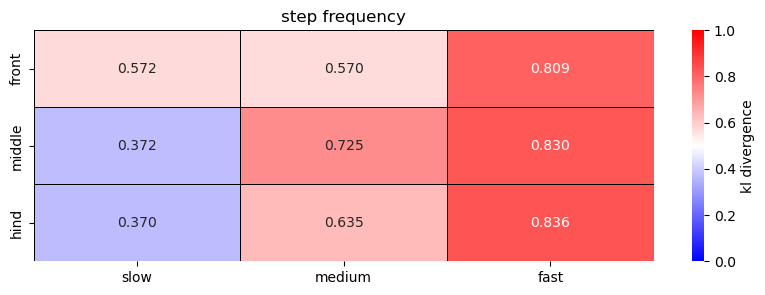

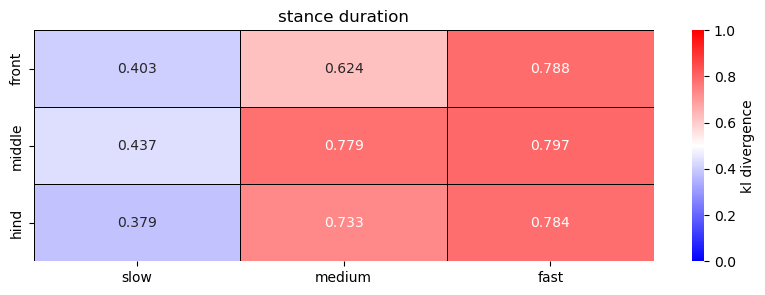

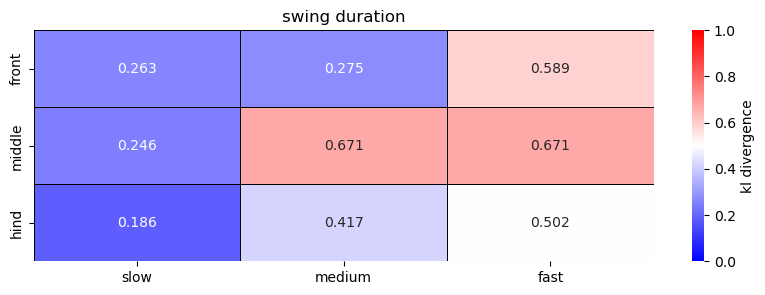

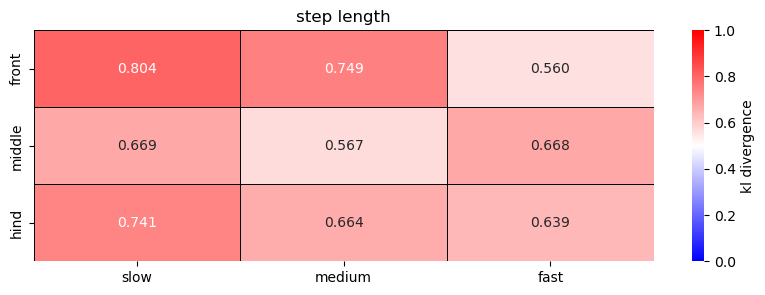

In [363]:
def plot_kl_div_heatmap(metric, binsize, save=False):
    metric_files = glob.glob(f'treadmill_pape/npy_files/*/*{metric}*')
    print(metric_files)
    ball_metric = np.load(metric_files[0])
    bowl_metric = np.load(metric_files[1])
    treadmill_metric = np.load(metric_files[2])

    fig = plt.figure(figsize=(10,3))
    ax = plt.axes()
    #cols = ['slow D-F', 'slow D-T', 'med D-F', 'med D-T','fast D-F', 'fast D-T']
    cols = ['slow', 'medium', 'fast']
    leg_pairs = ['front','middle', 'hind']
    heatmap_df = pd.DataFrame(index=leg_pairs, columns=cols)

    velo_codes = [[0,1,2], [3,4,5], [6,7,8]]
    #print(metric)

    for i in range(len(leg_pairs)):
        slow_D = treadmill_metric[0][np.where(treadmill_metric[1] == velo_codes[i][0])]
        slow_F = bowl_metric[0][np.where(bowl_metric[1] == velo_codes[i][0])]
        slow_T = ball_metric[0][np.where(ball_metric[1] == velo_codes[i][0])]

        med_D = treadmill_metric[0][np.where(treadmill_metric[1] == velo_codes[i][1])]
        med_F = bowl_metric[0][np.where(bowl_metric[1] == velo_codes[i][1])]
        med_T = ball_metric[0][np.where(ball_metric[1] == velo_codes[i][1])]

        fast_D = treadmill_metric[0][np.where(treadmill_metric[1] == velo_codes[i][2])]
        fast_F = bowl_metric[0][np.where(bowl_metric[1] == velo_codes[i][2])]
        fast_T = ball_metric[0][np.where(ball_metric[1] == velo_codes[i][2])]
        
        lower = np.min([np.min(slow_D), np.min(slow_F), np.min(slow_T), 
                        np.min(med_D), np.min(med_F), np.min(med_T),
                        np.min(fast_D), np.min(fast_F), np.min(fast_T)])
        
        upper = np.max([np.max(fast_D), np.max(fast_F), np.max(fast_T),
                        np.max(med_D), np.max(med_F), np.max(med_T),
                        np.max(slow_D), np.max(slow_F), np.max(slow_T)])
        ranges = (lower, upper)

        slow_D_distr = np.histogram(slow_D, bins=binsize, range = ranges)[0] / np.histogram(slow_D, bins=binsize, range = ranges)[0].sum()
        slow_F_distr  = np.histogram(slow_F, bins=binsize, range = ranges)[0] / np.histogram(slow_F, bins=binsize, range = ranges)[0].sum()
        slow_T_distr  = np.histogram(slow_T, bins=binsize, range = ranges)[0] / np.histogram(slow_T, bins=binsize, range = ranges)[0].sum()

        med_D_distr  = np.histogram(med_D, bins=binsize, range = ranges)[0] / np.histogram(med_D, bins=binsize, range = ranges)[0].sum()
        med_F_distr  = np.histogram(med_F, bins=binsize, range = ranges)[0] / np.histogram(med_F, bins=binsize, range = ranges)[0].sum()
        med_T_distr  = np.histogram(med_T, bins=binsize, range = ranges)[0] / np.histogram(med_T, bins=binsize, range = ranges)[0].sum()

        fast_D_distr  = np.histogram(fast_D, bins=binsize, range = ranges)[0] / np.histogram(fast_D, bins=binsize, range = ranges)[0].sum()
        fast_F_distr  = np.histogram(fast_F, bins=binsize, range = ranges)[0] / np.histogram(fast_F, bins=binsize, range = ranges)[0].sum()
        fast_T_distr  = np.histogram(fast_T, bins=binsize, range = ranges)[0] / np.histogram(fast_T, bins=binsize, range = ranges)[0].sum()
        
        #print(slow_D_distr[np.where(slow_D_distr==0)], slow_F_distr[np.where(slow_F_distr==0)], slow_T_distr[np.where(slow_T_distr==0)])
        slow_D_distr[slow_D_distr == 0] = 0.000001
        slow_F_distr[slow_F_distr == 0] = 0.000001
        slow_T_distr[slow_T_distr == 0] = 0.000001
        med_D_distr[med_D_distr == 0] = 0.000001
        med_F_distr[med_F_distr == 0] = 0.000001
        med_T_distr[med_T_distr == 0] = 0.000001
        fast_D_distr[fast_D_distr == 0] = 0.000001
        fast_F_distr[fast_F_distr == 0] = 0.000001
        fast_T_distr[fast_T_distr == 0] = 0.000001
        
        slow_DF_kl = stats.entropy(slow_F_distr, slow_D_distr)
        slow_DT_kl = stats.entropy(slow_F_distr, slow_T_distr)
        
        med_DF_kl = stats.entropy(med_F_distr, med_D_distr)
        med_DT_kl = stats.entropy(med_F_distr, med_T_distr)

        fast_DF_kl = stats.entropy(fast_F_distr, fast_D_distr)
        fast_DT_kl = stats.entropy(fast_F_distr, fast_T_distr)

        heatmap_df.loc[leg_pairs[i], 'slow'] = 1 - (slow_DF_kl / (slow_DF_kl + slow_DT_kl)) #if slow_DF_kl + slow_DT_kl == 0 else 0.5
        print(slow_DF_kl, slow_DT_kl)
        heatmap_df.loc[leg_pairs[i], 'medium'] = 1 - (med_DF_kl / (med_DF_kl + med_DT_kl))
        heatmap_df.loc[leg_pairs[i], 'fast'] = 1 - (fast_DF_kl / (fast_DF_kl + fast_DT_kl))
        
        
    #cmap = ListedColormap(['tab:blue', 'silver', 'tab:red'])
    cmap = 'bwr'
    #cmap='coolwarm'
    
    heatmap = sns.heatmap(heatmap_df.astype(float), ax=ax, cmap=cmap, vmin=0, vmax=1, \
                         linewidth=0.5, linecolor='black', cbar_kws={'label': 'kl divergence'}, annot=True, fmt='.3f')

    #plt.yticks(rotation=0)
    ax.set_title(metric.split('_')[0]+ ' '+ metric.split('_')[1])

    if save:
        plt.savefig(f'treadmill_pape/{metric}_kl_div_{date.today()}.png', dpi=200)
        plt.savefig(f'treadmill_pape/{metric}_kl_div_{date.today()}.pdf', dpi=200)
        plt.savefig(f'treadmill_pape/{metric}_kl_div_{date.today()}.svg', dpi=200)   
        
    return heatmap_df
        
metrics = ['step_frequency', 'stance_duration', 'swing_duration', 'step_length']
for metric in metrics:
    heatmap_df = plot_kl_div_heatmap(metric, binsize=50, save=True)